# Question1 - Synthetic Data Generation for Financial Modeling (You must answer two questions from questions 1 to 3.)

Objective: Generate synthetic financial data for asset prices to perform predictive modeling and analyze trends.

- Generate a synthetic time series for the daily closing prices of two stocks over two years using a generative model (e.g., Generative Adversarial Networks (GANs) or other generative algorithms).
- Calculate and plot the generated data's daily returns, volatility, and moving averages. Compare these values to the original data and assess differences and similarities in performance.
- Discuss how synthetic data generation could support risk modeling and decision-making for firms lacking historical data or when preparing for hypothetical scenarios.


## Fetch Real Stock Data(AAPL, NVDA)

In [ ]:
import numpy as np
import pandas as pd
import random
import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt
import yfinance as yf

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Call set_seed before training the GAN
set_seed(42)

def fetch_realtime_stock_data(ticker_symbol, period="2y", interval="1d"):
    stock_data = yf.download(ticker_symbol, period=period, interval=interval)
    stock_data = stock_data.reset_index()
    stock_data.columns = [ col[0]  for col in stock_data.columns]
    return stock_data

original_aapl = fetch_realtime_stock_data("TSLA")["Close"]
original_nvda = fetch_realtime_stock_data("NVDA")["Close"]

original_aapl, original_nvda

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


(0      167.869995
 1      169.910004
 2      183.199997
 3      182.860001
 4      182.919998
           ...    
 497    330.239990
 498    311.179993
 499    320.720001
 500    338.739990
 501    346.000000
 Name: Close, Length: 502, dtype: float64,
 0       15.317000
 1       16.038000
 2       16.518999
 3       16.270000
 4       15.827000
           ...    
 497    146.270004
 498    146.759995
 499    141.979996
 500    140.149994
 501    147.009995
 Name: Close, Length: 502, dtype: float64)

## Define the GAN

In [ ]:
# Define Generator class
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.model = nn.Sequential(
            nn.Linear(self.latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

# Define Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Dropout(p=0.2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Function to train the discriminator
def train_discriminator(discriminator, optimizer_D, real_data, fake_data, loss_fn):
    optimizer_D.zero_grad()

    # Train on real data
    prediction_real = discriminator(real_data)
    error_real = loss_fn(prediction_real, torch.ones_like(prediction_real))
    error_real.backward()

    # Train on fake data
    prediction_fake = discriminator(fake_data.detach())
    error_fake = loss_fn(prediction_fake, torch.zeros_like(prediction_fake))
    error_fake.backward()

    optimizer_D.step()

    return error_real + error_fake

# Function to train the generator
def train_generator(generator, discriminator, optimizer_G, fake_data, loss_fn):
    optimizer_G.zero_grad()

    prediction = discriminator(fake_data)
    error = loss_fn(prediction, torch.ones_like(prediction))
    error.backward()

    optimizer_G.step()

    return error

# Training function
def train_gan(generator, discriminator, real_data, latent_dim=128, batch_size=502, lr=3e-4, epochs=5000, print_interval=1000):
    optimizer_G = optim.Adam(generator.parameters(), lr=lr)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    for epoch in range(1, epochs + 1):
        # Generate fake data
        fake_data = generator(Variable(torch.randn(batch_size, latent_dim)))

        # Train discriminator
        d_loss = train_discriminator(discriminator, optimizer_D, real_data, fake_data, loss_fn)

        # Train generator
        g_loss = train_generator(generator, discriminator, optimizer_G, fake_data, loss_fn)

        if epoch % print_interval == 0:
            print(f"Epoch: {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

    # Generate final synthetic data
    generated_data = generator(Variable(torch.randn(batch_size, latent_dim))).detach().numpy()
    return generated_data


# Instantiate models
generator = Generator()
discriminator = Discriminator()

## Generate the data using GAN

Epoch: 1000, D Loss: 1.3838534355163574, G Loss: 0.645423412322998
Epoch: 2000, D Loss: 1.3961915969848633, G Loss: 0.6206017732620239
Epoch: 3000, D Loss: 1.3871955871582031, G Loss: 0.6986700892448425
Epoch: 4000, D Loss: 1.3533985614776611, G Loss: 0.6899318695068359
Epoch: 5000, D Loss: 1.3961870670318604, G Loss: 0.8378434777259827


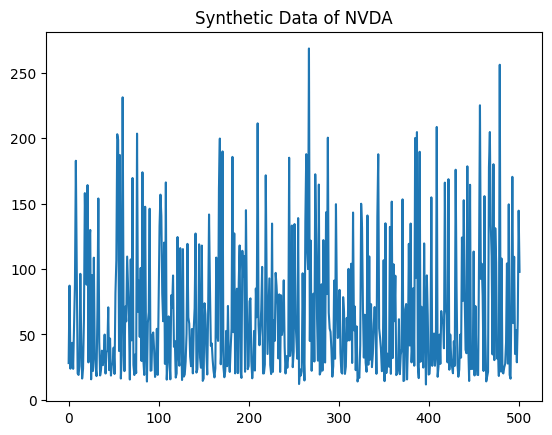

In [ ]:
# Training
real_nvda = torch.Tensor(original_nvda.values).view(-1, 1)  # Assume `data` is provided as a 1D array
synthetic_nvda = train_gan(generator, discriminator, real_nvda)

# Plot the generated_data
plt.plot(synthetic_nvda)
plt.title("Synthetic Data of NVDA")
plt.show()

In [ ]:
# Training
real_aapl = torch.Tensor(original_aapl.values).view(-1, 1)  # Assume `data` is provided as a 1D array
synthetic_aapl = train_gan(generator, discriminator, real_aapl)

# Plot the generated_data
plt.plot(synthetic_aapl)
plt.title("Synthetic Data of AAPL")
plt.show()

## Result Comparsion

In [ ]:
def calculate_indicators(data, window=20):
    """
    Calculate daily returns, rolling volatility, and moving averages.
    """
    # Ensure data is in DataFrame format
    if isinstance(data, pd.Series):
        data = data.to_frame('Price')
    elif isinstance(data, pd.DataFrame) and data.shape[1] == 1:
        data.columns = ['Price']

    indicators = pd.DataFrame(index=data.index)
    indicators['Price'] = data['Price']

    # Calculate daily returns
    indicators['Daily_Return'] = indicators['Price'].pct_change()

    # Calculate moving average
    indicators['Moving_Avg'] = indicators['Price'].rolling(window=window).mean()

    # Calculate rolling volatility (standard deviation of daily returns)
    indicators['Volatility'] = indicators['Daily_Return'].rolling(window=window).std()

    return indicators



In [ ]:
real_aapl_metric = calculate_indicators(original_aapl)
synthetic_aapl_metric = calculate_indicators(pd.DataFrame(synthetic_aapl))

real_nvda_metric = calculate_indicators(original_nvda)
synthetic_nvda_metric = calculate_indicators(pd.DataFrame(synthetic_nvda))

In [ ]:
# Plot AAPL
plt.figure(figsize=(10, 5))
plt.plot(original_aapl, label="Original AAPL")
plt.plot(synthetic_aapl, label="Synthetic AAPL", linestyle="--")
plt.legend()
plt.title("AAPL Original vs. Synthetic Prices")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(real_aapl_metric["Daily_Return"], label="Original AAPL Daily Return")
plt.plot(synthetic_aapl_metric["Daily_Return"], label="Synthetic AAPL Daily Return", linestyle="--")
plt.legend()
plt.title("AAPL Daily Return)")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(real_aapl_metric["Moving_Avg"], label="Original AAPL MA20")
plt.plot(synthetic_aapl_metric["Moving_Avg"], label="Synthetic AAPL MA20", linestyle="--")
plt.legend()
plt.title("AAPL Moving Averages (20 days)")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(real_aapl_metric["Volatility"], label="Original AAPL Volatility")
plt.plot(synthetic_aapl_metric["Volatility"], label="Synthetic AAPL Volatility", linestyle="--")
plt.legend()
plt.title("AAPL Volatility")
plt.show()

# Plot NVDA
plt.figure(figsize=(10, 5))
plt.plot(original_nvda, label="Original NVDA")
plt.plot(synthetic_nvda, label="Synthetic NVDA", linestyle="--")
plt.legend()
plt.title("NVDA Original vs. Synthetic Prices")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(real_nvda_metric["Moving_Avg"], label="Original NVDA MA20")
plt.plot(synthetic_nvda_metric["Moving_Avg"], label="Synthetic NVDA MA20", linestyle="--")
plt.legend()
plt.title("NVDA Moving Averages (20 days)")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(real_nvda_metric["Moving_Avg"], label="Original NVDA MA20")
plt.plot(synthetic_nvda_metric["Moving_Avg"], label="Synthetic NVDA MA20", linestyle="--")
plt.legend()
plt.title("NVDA Moving Averages (20 days)")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(real_nvda_metric["Volatility"], label="Original NVDA Volatility")
plt.plot(synthetic_nvda_metric["Volatility"], label="Synthetic NVDA Volatility", linestyle="--")
plt.legend()
plt.title("NVDA Volatility")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(real_nvda_metric["Daily_Return"], label="Original NVDA Daily Return")
plt.plot(synthetic_nvda_metric["Daily_Return"], label="Synthetic Daily Return", linestyle="--")
plt.legend()
plt.title("NVDA Daily Return)")
plt.show()


# Question2 - Creating a Financial Chatbot

Objective: Develop a chatbot that can assist with basic financial queries and provide simple financial advice based on market data.

- Create a chatbot using a generative AI model (such as GPT) that can:
  - Answer questions about current or synthetic stock performance.
  - Explain basic financial terms (e.g., “What is volatility?”).
  - Provide simple advice or suggestions based on synthetic data generated in Question 1 (e.g., “Is now a good time to invest in stock A or B?” based on recent trends).

- Identify and discuss limitations and risks associated with relying on a generative AI-powered chatbot for financial advice, especially in live trading scenarios.

In [ ]:
!pip install -q python-dotenv langchain_openai

ERROR: Operation cancelled by user


In [ ]:
# Import necessary libraries
import dotenv
import os
from langchain_openai import OpenAI
from langchain.prompts import PromptTemplate
import pandas as pd

# Load the .env file to access API keys securely
dotenv.load_dotenv()
secret_key = os.getenv('OPENAI_API_KEY')

#

# Configure the OpenAI model with parameters suitable for fact-grounded responses
llm = OpenAI(
    openai_api_key=secret_key,
    model="gpt-3.5-turbo-instruct",
    temperature=0  # Keeps responses fact-based
)

# Define prompt templates for different types of queries
# 1. Basic Financial Term Explanation
term_template = PromptTemplate(template="""
You are a financial assistant. Explain the following financial term in simple language: {term}.
""", input_variables=["term"])

# 2. Stock Performance Query (compare real and synthetic data)
stock_performance_template = PromptTemplate(template="""
You are a financial assistant. Here is the recent performance for the requested stock:
Real Data:
{real_data}

Synthetic Data:
{synthetic_data}

Based on these trends, provide a analysis of the performance of stock {stock}.
""", input_variables=["real_data", "synthetic_data", "stock"])

# 3. Investment Advice Query using DataFrames for each stock
advice_template = PromptTemplate(template="""
You are a financial assistant providing simple investment suggestions based on recent trends in synthetic stock data.
Here is the recent performance for each stock:

Stock {stock_a}:
{stock_a_data}

Stock {stock_b}:
{stock_b_data}

Based on this information, suggest which stock might be a better investment currently.
""", input_variables=["stock_a", "stock_a_data", "stock_b", "stock_b_data"])


# Helper function to format stock data for prompt input
def format_stock_data(df):
    # Use the most recent row of data for a summary
    latest_data = df.iloc[-1]
    data_str = (
        f"Price: {latest_data['Price']}, "
        f"Daily Return: {latest_data['Daily_Return']:.4f}, "
        f"Moving Average (20-day): {latest_data['Moving_Avg']}, "
        f"Volatility: {latest_data['Volatility']:.4f}"
    )
    return data_str

# Function to get explanation for financial terms
def explain_term(term):
    response = llm.invoke(term_template.format(term=term))
    return response

# Function to get stock performance summary by comparing real and synthetic data
def get_stock_performance(stock, real_df, synthetic_df):
    real_data_str = format_stock_data(real_df)
    synthetic_data_str = format_stock_data(synthetic_df)
    response = llm.invoke(stock_performance_template.format(
        real_data=real_data_str,
        synthetic_data=synthetic_data_str,
        stock=stock
    ))
    return response

# Function to get investment advice by comparing two stocks' performance data
def get_investment_advice(stock_a, stock_b, stock_a_df, stock_b_df):
    stock_a_data_str = format_stock_data(stock_a_df)
    stock_b_data_str = format_stock_data(stock_b_df)
    response = llm.invoke(advice_template.format(
        stock_a=stock_a,
        stock_a_data=stock_a_data_str,
        stock_b=stock_b,
        stock_b_data=stock_b_data_str
    ))
    return response

# Example Usage

# Explain a financial term
term_explanation = explain_term("volatility")
print("Term Explanation:", term_explanation)

# Get stock performance summary for "Stock A"
stock_performance = get_stock_performance("AAPL", real_aapl_metric, synthetic_aapl_metric)
print("Stock Performance:", stock_performance)

# Get investment advice between "Stock A" and "Stock B" using their DataFrames
investment_advice = get_investment_advice("AAPL", "NVDA", synthetic_aapl_metric, synthetic_nvda_metric)
print("Investment Advice:", investment_advice)


# Question3 - Sentiment Analysis on Financial News Articles

Objective: Use a generative AI model to perform sentiment analysis on financial news articles and understand its impact on stock movements.

- Collect or generate a set of synthetic financial news articles about stocks A and B. Include both positive and negative sentiment to simulate a realistic news cycle.
- Use a generative AI model or pre-trained transformer (e.g., OpenAI’s GPT, BERT) to perform sentiment analysis on the articles. Categorize each article as positive, negative, or neutral.
- Calculate the overall sentiment score and analyze its correlation with both the original data and synthetic stock price movements from Question 1. Describe any observed relationships and discuss the reliability of using sentiment analysis in trading strategies.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install -q transformers

Showing how the models work:

In [ ]:
from transformers import pipeline

# This is a public model on hugging face that is specifically trained to calculate the sentiment on financial news
sentiment_pipeline = pipeline(model = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# showing how it works
data = ["The total return for Apple (AAPL) stock is 21.93% over the past 12 months. So far it's up 17.04% this year.",
        # changing the word 'up' for 'down' changes from 99.9% positive to 99.9% negative
        "As of October 2, 2024, Nvidia's stock was down 135.6% YTD. This is well ahead of the Zacks Semiconductor – General industry and The Technology Select Sector SPDR Fund XLK ETF, which were up 102.2% and 14.4%, respectively",
        'I love you',
        'I hate you',
        "I hate how much I love you"
        ]
sentiment_pipeline(data)

# Notice that the last 2 are neutral ... they are not related to financial data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

[{'label': 'positive', 'score': 0.999710738658905},
 {'label': 'negative', 'score': 0.9986732006072998},
 {'label': 'neutral', 'score': 0.9997156262397766},
 {'label': 'neutral', 'score': 0.9994131326675415},
 {'label': 'neutral', 'score': 0.9994729161262512}]

In [ ]:
sentiment_pipeline = pipeline(model = "finiteautomata/bertweet-base-sentiment-analysis")

# showing how it works
data = ["The total return for Apple (AAPL) stock is 21.93% over the past 12 months. So far it's up 17.04% this year.",
        "As of October 2, 2024, Nvidia's stock was up 135.6% YTD. This is well ahead of the Zacks Semiconductor – General industry and The Technology Select Sector SPDR Fund XLK ETF, which were up 102.2% and 14.4%, respectively",
        'I love you',
        'I hate you',
        "I hate how much I love you"]
sentiment_pipeline(data)

# This one is generally more accurate but we are specifically targeting financial data
# Notice the first sentence... financial model is much better

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'POS', 'score': 0.5761789083480835},
 {'label': 'POS', 'score': 0.8878068327903748},
 {'label': 'POS', 'score': 0.9916695356369019},
 {'label': 'NEG', 'score': 0.9806600213050842},
 {'label': 'NEG', 'score': 0.8835533261299133}]

### Quick comments on sentiment models
Above we have shown two different transformer sentiment analysis models. One is meant to handle technical financial commentary and data while the other is intended to handle informal general text.

Below we can see that the general model performs better for less technical inputs. The articles below are mostly comprised with informal opinions with sparse heavily-technical financial data. This makes sense because an article that was technical would't be interesting to read and these articles below are opinion peices. Maybe a better application for the financial sentiment model would be an earnings report or isolated technical snippets the articles.

Financial opinionated sentences:

In [ ]:
!wget https://huggingface.co/datasets/takala/financial_phrasebank/resolve/main/data/FinancialPhraseBank-v1.0.zip
!unzip -o -q FinancialPhraseBank-v1.0.zip
!rm FinancialPhraseBank-v1.0.zip*

--2024-11-21 19:10:21--  https://huggingface.co/datasets/takala/financial_phrasebank/resolve/main/data/FinancialPhraseBank-v1.0.zip
Resolving huggingface.co (huggingface.co)... 18.172.134.4, 18.172.134.24, 18.172.134.88, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/datasets/financial_phrasebank/0e1a06c4900fdae46091d031068601e3773ba067c7cecb5b0da1dcba5ce989a6?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27FinancialPhraseBank-v1.0.zip%3B+filename%3D%22FinancialPhraseBank-v1.0.zip%22%3B&response-content-type=application%2Fzip&Expires=1732475421&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMjQ3NTQyMX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kYXRhc2V0cy9maW5hbmNpYWxfcGhyYXNlYmFuay8wZTFhMDZjNDkwMGZkYWU0NjA5MWQwMzEwNjg2MDFlMzc3M2JhMDY3YzdjZWNiNWIwZGExZGNiYTVjZTk4OWE2P3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZ

In [ ]:
base_path = 'FinancialPhraseBank-v1.0/'

files = ['Sentences_50Agree.txt',
         'Sentences_66Agree.txt',
         'Sentences_75Agree.txt',
         'Sentences_AllAgree.txt'
         ]

sentence_data = []

for file in files:
  with open(base_path + file, 'r', encoding='ISO-8859-1') as f:
    for line in f:
      if '.@' in line:
        sentence, label = line.rsplit('@', 1)
        sentence = sentence.strip()  # Remove extra spaces
        label = label.strip()  # Remove extra spaces
        sentence_data.append({'sentence': sentence, 'true_label': label})

df = pd.DataFrame(sentence_data)
df[:5]

,sentence,true_label
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


Example of data

In [ ]:
print(df.iloc[0]['sentence'])
print(df.iloc[0]['true_label'])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
neutral


In [ ]:
class ArticleAnalysis():
  def __init__(self, title="Article", text=''):
    self.title = str(title)
    self.text = str(text)
    self.sentiment_results = None
    self.model = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"

  def __repr__(self):
        return f"ArticleAnalysis(title={self.title!r}, text_length={len(self.text)})"

  def split_text(self, max_length=256):
    words = self.text.split()  # split into words
    chunks = []
    current_chunk = []
    current_length = 0

    for word in words:
        current_length += len(word) + 1
        if current_length <= max_length:
            current_chunk.append(word)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [word]
            current_length = len(word) + 1

    if current_chunk:
        chunks.append(" ".join(current_chunk))
    return chunks

  def get_sentiment(self, model = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis" ,silent=False):

    '''
    If silent is true, we return the results (not print). If silent=False we print them.
    '''

    # check if we have cached results, if so, use them
    if self.sentiment_results and self.model == model:
      results = self.sentiment_results
    else:
      chunks = self.split_text()
      results = []
      sentiment_pipeline = pipeline(model = model)

      for chunk in chunks:
        result = sentiment_pipeline(chunk)
        results.append(result)
      # cache results
      self.sentiment_results = results

    self.model = model

    if silent:
      return results
    else:
      for i, result in enumerate(results):
        print(f"Chunk {i + 1}: {result}")

    return None


  def aggregate_sentiment(self, verbose=True):
    '''
    Aggregates the sentiment of all chunks. Note this only works with base model.
    '''
    results = self.get_sentiment(silent=True, model = self.model)

    if self.model == "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis":
      sentiment_counts = {"positive": 0, "negative": 0, "neutral": 0}
      for chunk_result in results:
          if chunk_result:
              label = chunk_result[0]['label']
              sentiment_counts[label] += 1

      if verbose:
        total = len(results)
        print(f"The article is {round(sentiment_counts['positive'] / total, 2)}% positive\nThe article is {round(sentiment_counts['neutral'] / total, 2)}% neutral\nThe article is {round(sentiment_counts['negative'] / total, 2)}% negative")

    elif self.model == "finiteautomata/bertweet-base-sentiment-analysis":
      sentiment_counts = {"POS": 0, "NEG": 0, "NEU": 0}
      for chunk_result in results:
          if chunk_result:
              label = chunk_result[0]['label']
              sentiment_counts[label] += 1

      if verbose:
        total = len(results)
        print(f"The article is {round(sentiment_counts['POS'] / total, 2)}% positive\nThe article is {round(sentiment_counts['NEU'] / total, 2)}% neutral\nThe article is {round(sentiment_counts['NEG'] / total, 2)}% negative")

    else:
      print("The model used for sentiment analysis is not supported for this method")
      sentiment_counts = None

    return sentiment_counts

Can change which sentiment model we use:

- mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis
- finiteautomata/bertweet-base-sentiment-analysis
- LiYuan/amazon-review-sentiment-analysis

- more here: https://huggingface.co/models?search=sentiment-analysis


how to change model:

```
my_article = ArticleAnalysis(title="my_article", text=article_text)
my_article.get_sentiment(model='finiteautomata/bertweet-base-sentiment-analysis')
```

### Real Tesla Article

In [ ]:
# https://finance.yahoo.com/news/tesla-stock-sell-off-after-robotaxi-event-could-be-just-the-beginning-pros-warn-155630709.html

with open("tesla_article_oct14.txt", 'r', encoding='utf-8') as file:
    tsla_article_oct_14 = file.read()

tsla_article_oct_14

"Fundamentals over hype.\n\nIndeed that’s the lesson for Tesla (TSLA) investors after the EV maker’s disappointing robotaxi event last week exposed a disconnect between the stock’s lofty valuation and reality.\n\nA lack of details surrounding the rollout plan and regulatory approval, plus no mention of a more affordable regular EV, left Wall Street wanting more.\n\nCFRA analyst Garrett Nelson likened the event to “watching a movie with a lot of plot twists and special effects, and at the end, you're walking out scratching your head.”\n\nSafe to say analysts “scratching their heads” was probably not the reaction Musk was hoping for when showing off the Cybercab and Robovan concepts. Now, the big issue for investors is reevaluating Tesla’s stock price.\n\nOn Friday, more than $60 billion was wiped off of Tesla’s valuation in a sell-off, a sharp reversal from the stock’s recent momentum. Shares had soared over 70% since Musk started touting AI in April. The rally brought Tesla’s market va

In [ ]:
# https://www.investors.com/news/tesla-stock-elon-musk-robotaxi-event/

with open("tesla_article_oct3.txt", 'r', encoding='utf-8') as file:
    tsla_article_oct_3 = file.read()

tsla_article_oct_3

'Tesla\'s (TSLA) big October has arrived and, with third-quarter deliveries out of the way, investor attention is now completely on the global EV giant\'s scheduled reveal of the highly anticipated robotaxi on Oct. 10 at an event in Los Angeles. Investors appear to be waiting until then before making any big Tesla stock bets.\n\nRobotaxi event invitations were officially sent to Tesla investors on Sept. 25 and while most of the details are still under wraps, Chief Executive Elon Musk is setting sky-high expectations for the event.\n\n"This will be one for the history books," Musk posted to X on Sept. 25, along with a photo of the event announcement. "We, Robot," the banner reads. "10.10 Los Angeles."\n\n"We think the stakes are high and there is more risk to the downside than upside given the stock\'s recent run-up and likelihood that the event could disappoint," CFRA analyst Garrett Nelson wrote Wednesday.\n\n"We also note the stock price run-up and then \'sell the news\' pattern of m

In [ ]:
# https://www.investors.com/news/tesla-stock-earnings-q3-elon-musk/

with open("tesla_article_oct23.txt", 'r', encoding='utf-8') as file:
    tsla_article_oct_23 = file.read()

tsla_article_oct_23

'Tesla (TSLA) announced a surprise third-quarter earnings gain late Wednesday, with quarterly profit growing 9%, capping off a big month of announcements for the EV giant. Revenue came in light. But Tesla stock surged after the close Wednesday.\n\nOn the Tesla earnings call, Chief Executive Elon Musk was calmly bullish throughout, upbeat on full self-driving, vehicle deliveries, storage and more.\n\nThat\'s A Wrap\nThe Tesla earnings call ended at 6:37 p.m. ET, with Elon Musk bullish on a variety of fronts after Tesla reported strong earnings and margins.\n\nTesla stock is up 12% in extended trading, adding to gains as Musk spoke.\n\n6:35 p.m. ET\nMusk: \'Some Chance\' FSD HW 3.0 Won\'t Reach Self-Driving\nMusk said that Hardware 4 has "several times the capability of Hardware 3 and that it takes a lot of effort to sort of squeeze that functionality out of Hardware 3." The Tesla chief added that there is "some chance" Hardware 3 does not "achieve the safety level that allows for unsupe

In [ ]:
# https://www.barrons.com/articles/tesla-stock-china-incentives-58ec1082

with open("tesla_article_oct28.txt", 'r', encoding='utf-8') as file:
    tsla_article_oct_28 = file.read()

tsla_article_oct_28

'A big reason Tesla stock jumped 22% after reporting third-quarter earnings can be summed up in one word: growth.\n\nNow Tesla’s stock chart is looking better, leading traders to look for an all-important breakout.\n\nFor the third quarter, Tesla reported better-than-expected profit margins while management said it expected to grow electric-vehicle deliveries in 2024 from 2023. That implies about 515,000 deliveries in the fourth quarter, a record and about 25,000 better than Wall Street was projecting, according to FactSet.\n\nIt’s a big number for the final quarter of the year. One thing Tesla will use to achieve the record is deals for car buyers.\n\nOver the weekend, Tesla extended its 0% financing offer for some qualifying purchases in China. Earlier discounts have helped. Tesla sold about 182,000 vehicles in China in the third quarter, a quarterly record for the company in that country and up about 66% year over year.\n\nTesla has 0% financing offers in the U.S. too. It sold about

In [ ]:
tsla_article_oct_14 = ArticleAnalysis(title="tsla_article_oct_14", text=tsla_article_oct_14)
tsla_article_oct_14.get_sentiment()
tsla_article_oct_14.aggregate_sentiment() # this only works for base model

Chunk 1: [{'label': 'negative', 'score': 0.9967041611671448}]
Chunk 2: [{'label': 'positive', 'score': 0.7387213706970215}]
Chunk 3: [{'label': 'neutral', 'score': 0.9989660978317261}]
Chunk 4: [{'label': 'positive', 'score': 0.9974949359893799}]
Chunk 5: [{'label': 'negative', 'score': 0.9971387386322021}]
Chunk 6: [{'label': 'negative', 'score': 0.9984440207481384}]
Chunk 7: [{'label': 'negative', 'score': 0.9972561001777649}]
Chunk 8: [{'label': 'negative', 'score': 0.9953014850616455}]
Chunk 9: [{'label': 'negative', 'score': 0.9985263347625732}]
Chunk 10: [{'label': 'positive', 'score': 0.9154166579246521}]
Chunk 11: [{'label': 'negative', 'score': 0.9966913461685181}]
Chunk 12: [{'label': 'negative', 'score': 0.6633055806159973}]
Chunk 13: [{'label': 'neutral', 'score': 0.9998780488967896}]
The article is 0.23% positive
The article is 0.15% neutral
The article is 0.62% negative


{'positive': 3, 'negative': 8, 'neutral': 2}

In [ ]:
tsla_article_oct_3 = ArticleAnalysis(title="tsla_article_oct_3", text=tsla_article_oct_3)
tsla_article_oct_3.get_sentiment()
tsla_article_oct_3.aggregate_sentiment() # this only works for base model

Chunk 1: [{'label': 'neutral', 'score': 0.9514315128326416}]
Chunk 2: [{'label': 'neutral', 'score': 0.9987479448318481}]
Chunk 3: [{'label': 'neutral', 'score': 0.9985595345497131}]
Chunk 4: [{'label': 'positive', 'score': 0.659092903137207}]
Chunk 5: [{'label': 'negative', 'score': 0.9975296854972839}]
Chunk 6: [{'label': 'positive', 'score': 0.9991016387939453}]
Chunk 7: [{'label': 'neutral', 'score': 0.9998520612716675}]
Chunk 8: [{'label': 'neutral', 'score': 0.9998440742492676}]
Chunk 9: [{'label': 'neutral', 'score': 0.9998799562454224}]
Chunk 10: [{'label': 'neutral', 'score': 0.9998824596405029}]
Chunk 11: [{'label': 'neutral', 'score': 0.9998807907104492}]
Chunk 12: [{'label': 'positive', 'score': 0.998484194278717}]
Chunk 13: [{'label': 'neutral', 'score': 0.9998329877853394}]
Chunk 14: [{'label': 'neutral', 'score': 0.9998338222503662}]
Chunk 15: [{'label': 'neutral', 'score': 0.9998443126678467}]
Chunk 16: [{'label': 'neutral', 'score': 0.9998641014099121}]
Chunk 17: [{'la

{'positive': 5, 'negative': 2, 'neutral': 14}

In [ ]:
tsla_article_oct_23 = ArticleAnalysis(title="tsla_article_oct_23", text=tsla_article_oct_23)
tsla_article_oct_23.get_sentiment()
tsla_article_oct_23.aggregate_sentiment() # this only works for base model

Chunk 1: [{'label': 'positive', 'score': 0.9996902942657471}]
Chunk 2: [{'label': 'positive', 'score': 0.9991274476051331}]
Chunk 3: [{'label': 'positive', 'score': 0.9997157454490662}]
Chunk 4: [{'label': 'negative', 'score': 0.9909868836402893}]
Chunk 5: [{'label': 'neutral', 'score': 0.9981873631477356}]
Chunk 6: [{'label': 'positive', 'score': 0.6797409057617188}]
Chunk 7: [{'label': 'positive', 'score': 0.9994564652442932}]
Chunk 8: [{'label': 'neutral', 'score': 0.9996907711029053}]
Chunk 9: [{'label': 'negative', 'score': 0.9959378242492676}]
Chunk 10: [{'label': 'neutral', 'score': 0.9997969269752502}]
Chunk 11: [{'label': 'positive', 'score': 0.9974043965339661}]
Chunk 12: [{'label': 'positive', 'score': 0.9997186064720154}]
Chunk 13: [{'label': 'positive', 'score': 0.9987592697143555}]
Chunk 14: [{'label': 'neutral', 'score': 0.9998798370361328}]
Chunk 15: [{'label': 'positive', 'score': 0.9990320205688477}]
Chunk 16: [{'label': 'positive', 'score': 0.9994280934333801}]
Chunk

{'positive': 26, 'negative': 5, 'neutral': 7}

In [ ]:
tsla_article_oct_28 = ArticleAnalysis(title="tsla_article_oct_28", text=tsla_article_oct_28)
tsla_article_oct_28.get_sentiment()
tsla_article_oct_28.aggregate_sentiment() # this only works for base model

Chunk 1: [{'label': 'positive', 'score': 0.9997079968452454}]
Chunk 2: [{'label': 'positive', 'score': 0.999698281288147}]
Chunk 3: [{'label': 'positive', 'score': 0.9991825222969055}]
Chunk 4: [{'label': 'positive', 'score': 0.9996867179870605}]
Chunk 5: [{'label': 'positive', 'score': 0.9997351765632629}]
Chunk 6: [{'label': 'negative', 'score': 0.9986661672592163}]
Chunk 7: [{'label': 'positive', 'score': 0.9997108578681946}]
Chunk 8: [{'label': 'positive', 'score': 0.9996744394302368}]
Chunk 9: [{'label': 'positive', 'score': 0.9996473789215088}]
Chunk 10: [{'label': 'neutral', 'score': 0.9551469683647156}]
Chunk 11: [{'label': 'neutral', 'score': 0.651505172252655}]
Chunk 12: [{'label': 'positive', 'score': 0.9982261061668396}]
Chunk 13: [{'label': 'positive', 'score': 0.9997190833091736}]
Chunk 14: [{'label': 'neutral', 'score': 0.9998691082000732}]
The article is 0.71% positive
The article is 0.21% neutral
The article is 0.07% negative


{'positive': 10, 'negative': 1, 'neutral': 3}

In [ ]:
# using the non-financial specific model
tsla_article_oct_14.get_sentiment(model = "finiteautomata/bertweet-base-sentiment-analysis" )
print('-'*70)
tsla_article_oct_14.aggregate_sentiment()

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Token indices sequence length is longer than the specified maximum sequence length for this model (139 > 128). Running this sequence through the model will result in indexing errors


IndexError: index out of range in self

In [ ]:
tsla_real_data = pd.read_csv('real_tsla_metric.csv')
tsla_real_data.shape

(483, 4)

In [ ]:
mean = tsla_real_data['Daily_Return'].mean()
std = tsla_real_data['Daily_Return'].std()
tsla_real_data['Standarized Daily_Return'] = (tsla_real_data['Daily_Return'] - mean) / std
# apply tanh(x)
tsla_real_data['Standarized Daily_Return'] = tsla_real_data['Standarized Daily_Return'].apply(np.tanh)
tsla_real_data.tail(10)

,Price,Daily_Return,Moving_Avg,Volatility,Standarized Daily_Return
473,296.910004,0.029044,242.886001,0.065036,0.607960
474,321.220001,0.081877,248.057001,0.062226,0.970757
475,350.000000,0.089596,254.599001,0.063934,0.980477
476,328.489990,-0.061457,260.045000,0.066673,-0.934373
477,330.239990,0.005327,265.490499,0.066706,0.077256
478,311.179993,-0.057716,270.004999,0.068895,-0.920556
479,320.720001,0.030658,275.005999,0.068768,0.634210
480,338.739990,0.056186,281.000498,0.068835,0.890576
481,346.000000,0.021432,287.401998,0.068521,0.465293
482,340.740112,-0.015202,293.756504,0.068368,-0.435312


In [ ]:
tsla_synthetic_data = pd.read_csv('synthetic_tsla.csv')
tsla_synthetic_data.head()

,Date,Price
0,2022-11-21,236.09453
1,2022-11-22,171.91377
2,2022-11-23,235.93727
3,2022-11-25,198.72232
4,2022-11-28,221.59300


In [ ]:
tsla_synthetic_data['Daily Returns'] = tsla_synthetic_data['Price'].pct_change()
mean = tsla_synthetic_data['Daily Returns'].mean()
std = tsla_synthetic_data['Daily Returns'].std()
tsla_synthetic_data['Standarized Daily_Return'] = (tsla_synthetic_data['Daily Returns'] - mean) / std
# apply tanh(x)
tsla_synthetic_data['Standarized Daily_Return'] = tsla_synthetic_data['Standarized Daily_Return'].apply(np.tanh)
tsla_synthetic_data.tail(10)

,Date,Price,Daily Returns,Standarized Daily_Return
492,2024-11-06,269.35266,0.299379,0.855128
493,2024-11-07,188.64432,-0.299638,-0.901475
494,2024-11-08,212.26927,0.125235,0.441442
495,2024-11-11,244.69560,0.152760,0.537484
496,2024-11-12,215.31690,-0.120062,-0.574450
497,2024-11-13,192.53938,-0.105786,-0.528803
498,2024-11-14,213.94820,0.111192,0.387990
499,2024-11-15,186.38910,-0.128812,-0.600789
500,2024-11-18,201.99763,0.083742,0.275849
501,2024-11-19,204.86609,0.014200,-0.036630


In [ ]:
# for Tesla Article Oct 14
for i in range(10, 17):
  print('-'*70)
  print(tsla_synthetic_data[tsla_synthetic_data['Date'] == '2024-10-{}'.format(i)])
  #print index
  print(tsla_synthetic_data.index[tsla_synthetic_data['Date'] == '2024-10-{}'.format(i)])

----------------------------------------------------------------------
           Date     Price  Daily Returns  Standarized Daily_Return
473  2024-10-10  161.7897      -0.314032                 -0.913162
Index([473], dtype='int64')
----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
474  2024-10-11  291.06836       0.799054                  0.998425
Index([474], dtype='int64')
----------------------------------------------------------------------
Empty DataFrame
Columns: [Date, Price, Daily Returns, Standarized Daily_Return]
Index: []
Index([], dtype='int64')
----------------------------------------------------------------------
Empty DataFrame
Columns: [Date, Price, Daily Returns, Standarized Daily_Return]
Index: []
Index([], dtype='int64')
----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
475  2024-10-14  209.

In [ ]:
for i in range(473 -20, 478-20):
  print('-'*70)
  print(tsla_real_data.iloc[i, :])

----------------------------------------------------------------------
Price                       238.770004
Daily_Return                 -0.009459
Moving_Avg                  244.741999
Volatility                    0.028706
Standarized Daily_Return     -0.304330
Name: 453, dtype: float64
----------------------------------------------------------------------
Price                       217.800003
Daily_Return                 -0.087825
Moving_Avg                  244.117500
Volatility                    0.035075
Standarized Daily_Return     -0.983357
Name: 454, dtype: float64
----------------------------------------------------------------------
Price                       219.160004
Daily_Return                  0.006244
Moving_Avg                  243.736500
Volatility                    0.034983
Standarized Daily_Return      0.101349
Name: 455, dtype: float64
----------------------------------------------------------------------
Price                       219.570007
Daily_Return  

In [ ]:
# for Tesla Article Oct 3
for i in range(1, 8):
  print('-'*70)
  print(tsla_synthetic_data[tsla_synthetic_data['Date'] == '2024-10-0{}'.format(i)])
  #print index
  print(tsla_synthetic_data.index[tsla_synthetic_data['Date'] == '2024-10-0{}'.format(i)])

----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
466  2024-10-01  218.04228       0.124828                  0.439932
Index([466], dtype='int64')
----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
467  2024-10-02  187.29419      -0.141019                 -0.635461
Index([467], dtype='int64')
----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
468  2024-10-03  321.23785       0.715151                  0.996596
Index([468], dtype='int64')
----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
469  2024-10-04  274.30612      -0.146097                 -0.649177
Index([469], dtype='int64')
------------------------------------------------------------

In [ ]:
for i in range(466, 471):
  print('-'*70)
  print(tsla_real_data.iloc[i, :])

----------------------------------------------------------------------
Price                       259.519989
Daily_Return                 -0.011390
Moving_Avg                  236.326502
Volatility                    0.058000
Standarized Daily_Return     -0.350008
Name: 466, dtype: float64
----------------------------------------------------------------------
Price                       257.549988
Daily_Return                 -0.007591
Moving_Avg                  236.753001
Volatility                    0.057411
Standarized Daily_Return     -0.258788
Name: 467, dtype: float64
----------------------------------------------------------------------
Price                       249.850006
Daily_Return                 -0.029897
Moving_Avg                  237.212502
Volatility                    0.057293
Standarized Daily_Return     -0.694045
Name: 468, dtype: float64
----------------------------------------------------------------------
Price                       248.979996
Daily_Return  

In [ ]:
# for Tesla Article Oct 23
for i in range(21, 26):
  print('-'*70)
  print(tsla_synthetic_data[tsla_synthetic_data['Date'] == '2024-10-{}'.format(i)])
  #print index
  print(tsla_synthetic_data.index[tsla_synthetic_data['Date'] == '2024-10-{}'.format(i)])

----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
480  2024-10-21  253.64581       0.101875                  0.350998
Index([480], dtype='int64')
----------------------------------------------------------------------
           Date     Price  Daily Returns  Standarized Daily_Return
481  2024-10-22  176.4518      -0.304338                 -0.905446
Index([481], dtype='int64')
----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
482  2024-10-23  182.73329       0.035599                   0.06169
Index([482], dtype='int64')
----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
483  2024-10-24  201.26302       0.101403                  0.349094
Index([483], dtype='int64')
--------------------------------------------------------------

In [ ]:
for i in range(480 - 20, 485 - 20):
  print('-'*70)
  print(tsla_real_data.iloc[i, :])

----------------------------------------------------------------------
Price                       218.850006
Daily_Return                 -0.008382
Moving_Avg                  239.441501
Volatility                    0.027352
Standarized Daily_Return     -0.278241
Name: 460, dtype: float64
----------------------------------------------------------------------
Price                       217.970001
Daily_Return                 -0.004021
Moving_Avg                  237.626501
Volatility                    0.026806
Standarized Daily_Return     -0.168613
Name: 461, dtype: float64
----------------------------------------------------------------------
Price                       213.649994
Daily_Return                 -0.019819
Moving_Avg                  235.458001
Volatility                    0.026590
Standarized Daily_Return     -0.528995
Name: 462, dtype: float64
----------------------------------------------------------------------
Price                       260.480011
Daily_Return  

In [ ]:
# for Tesla Article Oct 23
for i in range(24, 31):
  print('-'*70)
  print(tsla_synthetic_data[tsla_synthetic_data['Date'] == '2024-10-{}'.format(i)])
  #print index
  print(tsla_synthetic_data.index[tsla_synthetic_data['Date'] == '2024-10-{}'.format(i)])

----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
483  2024-10-24  201.26302       0.101403                  0.349094
Index([483], dtype='int64')
----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
484  2024-10-25  228.47615       0.135212                  0.477625
Index([484], dtype='int64')
----------------------------------------------------------------------
Empty DataFrame
Columns: [Date, Price, Daily Returns, Standarized Daily_Return]
Index: []
Index([], dtype='int64')
----------------------------------------------------------------------
Empty DataFrame
Columns: [Date, Price, Daily Returns, Standarized Daily_Return]
Index: []
Index([], dtype='int64')
----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
485  2024-10-28  18

In [ ]:
for i in range(483 - 20, 488 - 20):
  print('-'*70)
  print(tsla_real_data.iloc[i, :])

----------------------------------------------------------------------
Price                       260.480011
Daily_Return                  0.219190
Moving_Avg                  235.771001
Volatility                    0.057485
Standarized Daily_Return      0.999979
Name: 463, dtype: float64
----------------------------------------------------------------------
Price                       269.190002
Daily_Return                  0.033438
Moving_Avg                  236.207502
Volatility                    0.057697
Standarized Daily_Return      0.676206
Name: 464, dtype: float64
----------------------------------------------------------------------
Price                       262.510010
Daily_Return                 -0.024815
Moving_Avg                  236.251502
Volatility                    0.058031
Standarized Daily_Return     -0.617586
Name: 465, dtype: float64
----------------------------------------------------------------------
Price                       259.519989
Daily_Return  

## NVDA

In [ ]:
# https://finance.yahoo.com/news/nvidia-stock-rises-as-ceo-jensen-huang-touts-insane-chip-demand-162700341.html

with open("nvda_article_oct3.txt", 'r', encoding='utf-8') as file:
    nvda_article_oct_3 = file.read()

nvda_article_oct_3

'Nvidia (NVDA) stock jumped as much as 5% on Thursday as CEO Jensen Huang said demand for its next-generation Blackwell chips has been "insane."\n\nIn an interview with CNBC on Wednesday after the market close, Huang confirmed the chips are in "full production" despite recent design issues that caused some delays in customer rollouts.\n\n"Blackwell is as planned," Huang said. "Everybody wants to have the most and everybody wants to be first."\n\nBlackwell delays have caused concern for investors, with many looking to the rollout as the next big catalyst for the chipmaker after a recent stock slump fueled by a mid-July sell-off from the unwinding of the yen carry trade.\n\nSince then, markets have seen a rotation out of Big Tech while other macroeconomic factors, such as China trade fears, have also hampered Nvidia\'s stock price.\n\nBut investors and analysts alike remain largely confident in the trajectory of the artificial intelligence trade. Nvidia\'s stock is still up about 170% ov

In [ ]:
nvda_article_oct_3 = ArticleAnalysis(title="nvda_article_oct_3", text=nvda_article_oct_3)
nvda_article_oct_3.get_sentiment()
nvda_article_oct_3.aggregate_sentiment() # this only works for base model

Chunk 1: [{'label': 'positive', 'score': 0.9996745586395264}]
Chunk 2: [{'label': 'negative', 'score': 0.9929866194725037}]
Chunk 3: [{'label': 'negative', 'score': 0.9491676688194275}]
Chunk 4: [{'label': 'positive', 'score': 0.9996581077575684}]
Chunk 5: [{'label': 'positive', 'score': 0.9997064471244812}]
Chunk 6: [{'label': 'positive', 'score': 0.9995744824409485}]
Chunk 7: [{'label': 'positive', 'score': 0.9996237754821777}]
Chunk 8: [{'label': 'positive', 'score': 0.9996416568756104}]
The article is 0.75% positive
The article is 0.0% neutral
The article is 0.25% negative


{'positive': 6, 'negative': 2, 'neutral': 0}

In [ ]:
# https://finance.yahoo.com/news/nvidia-stock-tumbles-from-record-high-on-news-of-possible-us-chip-export-cap-asmls-dismal-earnings-163259227.html

with open("nvda_article_oct15.txt", 'r', encoding='utf-8') as file:
    nvda_article_oct_15 = file.read()

nvda_article_oct_15

'Nvidia (NVDA) stock sank 4.5% Tuesday, partially reversing its two week-rally and coming down from a record close the day before.\n\nThe stock\'s tumble began before the market opened in response to a Bloomberg report that Biden administration officials are considering capping US chip exports to certain countries. Bloomberg, citing unnamed sources, reported that potential regulations would focus on Persian Gulf countries in the interest of national security.\n\nThe stocks of fellow chipmakers Advanced Micro Devices (AMD) and Intel (INTC) also fell on the news. Intel declined to comment on the report. Nvidia and AMD did not immediately respond to requests from Yahoo Finance.\n\n"While NVDIA has not disclosed its sales to the Gulf region, the level of investment in AI from that region has been very substantial," DA Davidson analyst Gil Luria told Yahoo Finance. "More importantly, if the government continues to narrow the geographies chip companies can sell into, they are significantly n

In [ ]:
nvda_article_oct_15 = ArticleAnalysis(title="nvda_article_oct_15", text=nvda_article_oct_15)
nvda_article_oct_15.get_sentiment()
nvda_article_oct_15.aggregate_sentiment() # this only works for base model

Chunk 1: [{'label': 'negative', 'score': 0.9988007545471191}]
Chunk 2: [{'label': 'negative', 'score': 0.9074150919914246}]
Chunk 3: [{'label': 'negative', 'score': 0.9940052628517151}]
Chunk 4: [{'label': 'positive', 'score': 0.99908447265625}]
Chunk 5: [{'label': 'negative', 'score': 0.9987980127334595}]
Chunk 6: [{'label': 'negative', 'score': 0.9986904263496399}]
Chunk 7: [{'label': 'negative', 'score': 0.9978620409965515}]
Chunk 8: [{'label': 'positive', 'score': 0.9994176626205444}]
Chunk 9: [{'label': 'negative', 'score': 0.9983780384063721}]
Chunk 10: [{'label': 'positive', 'score': 0.9996856451034546}]
Chunk 11: [{'label': 'negative', 'score': 0.9836311340332031}]
Chunk 12: [{'label': 'positive', 'score': 0.9997072815895081}]
Chunk 13: [{'label': 'neutral', 'score': 0.9996697902679443}]
The article is 0.31% positive
The article is 0.08% neutral
The article is 0.62% negative


{'positive': 4, 'negative': 8, 'neutral': 1}

In [ ]:
# https://www.investors.com/news/technology/nvidia-stock-ai-chip-stocks-rise-analyst-comments/#:~:text=Artificial%20intelligence%20chip%20stocks%20rose,cycle%20in%20generative%20AI%20infrastructure.%22
with open("nvda_article_oct25.txt", 'r', encoding='utf-8') as file:
    nvda_article_oct_25 = file.read()

nvda_article_oct_25

'Artificial intelligence chip stocks rose Friday amid encouraging reports from Wall Street analysts. Nvidia (NVDA) stock was among the gainers.\n\nBofA Securities analyst Vivek Arya pounded the table for a portfolio of AI chip stocks, citing a "generational capex cycle in generative AI infrastructure."\n\nThe data center market "remains one of few bright spots" in third-quarter semiconductor earnings reports, he said.\n\nThe four major U.S. hyperscale cloud computing companies — Alphabet\'s (GOOGL) Google, Amazon (AMZN), Meta Platforms (META) and Microsoft (MSFT) — likely will continue to spend heavily on AI data center gear, he said. And that, in turn, bodes well for AI chipmakers.\n\nAI beneficiaries among chip stocks are Nvidia, Broadcom (AVGO), Marvell Technology (MRVL), Micron Technology (MU) and Advanced Micro Devices (AMD), Arya said. His "top picks" are Nvidia and Broadcom.\n\nOn the stock market today, Nvidia stock rose 0.8% to close at 141.54. Broadcom advanced 1% to 173. Mar

In [ ]:
nvda_article_oct_25 = ArticleAnalysis(title="nvda_article_oct_25", text=nvda_article_oct_25)
nvda_article_oct_25.get_sentiment()
nvda_article_oct_25.aggregate_sentiment() # this only works for base model

Chunk 1: [{'label': 'positive', 'score': 0.9997156262397766}]
Chunk 2: [{'label': 'positive', 'score': 0.9988399147987366}]
Chunk 3: [{'label': 'positive', 'score': 0.9994606375694275}]
Chunk 4: [{'label': 'positive', 'score': 0.9994774460792542}]
Chunk 5: [{'label': 'positive', 'score': 0.9996602535247803}]
Chunk 6: [{'label': 'positive', 'score': 0.9997175335884094}]
Chunk 7: [{'label': 'positive', 'score': 0.9995377063751221}]
Chunk 8: [{'label': 'positive', 'score': 0.9996174573898315}]
Chunk 9: [{'label': 'neutral', 'score': 0.9998824596405029}]
The article is 0.89% positive
The article is 0.11% neutral
The article is 0.0% negative


{'positive': 8, 'negative': 0, 'neutral': 1}

In [ ]:
# https://finance.yahoo.com/news/nvidia-stock-sinks-on-fears-of-ai-spending-slowdown-185105032.html#:~:text=Nvidia%20(NVDA)%20stock%20fell%20nearly,more%20than%20the%20broader%20market.

with open("nvda_article_oct31.txt", 'r', encoding='utf-8') as file:
    nvda_article_oct_31 = file.read()

nvda_article_oct_31

'Super Micro Computer (SMCI), a retailer of high-performance servers and liquid-cooled AI racks, has remained in the spotlight ever since Hindenburg Research published its damning report against the company back in August, prompting SMCI to then delay the filing of the requisite annual report, presumably in a bid to undertake a comprehensive internal review. Now, however, Super Micro Computer appears perilously close to a maelstrom, given that its accounting firm has resigned, and the requisite annual report has yet to be filed.\n\nSuper Micro Computer (SMCI), a retailer of high-performance servers and liquid-cooled AI racks, has remained in the spotlight ever since Hindenburg Research published its damning report against the company back in August, prompting SMCI to then delay the filing of the requisite annual report, presumably in a bid to undertake a comprehensive internal review. Now, however, Super Micro Computer appears perilously close to a maelstrom, given that its accounting 

In [ ]:
nvda_article_oct_31 = ArticleAnalysis(title="nvda_article_oct_31", text=nvda_article_oct_31)
nvda_article_oct_31.get_sentiment()
nvda_article_oct_31.aggregate_sentiment() # this only works for base model

Chunk 1: [{'label': 'neutral', 'score': 0.5908082127571106}]
Chunk 2: [{'label': 'negative', 'score': 0.988150954246521}]
Chunk 3: [{'label': 'neutral', 'score': 0.9994837045669556}]
Chunk 4: [{'label': 'negative', 'score': 0.9850902557373047}]
Chunk 5: [{'label': 'neutral', 'score': 0.999739944934845}]
Chunk 6: [{'label': 'negative', 'score': 0.9852065443992615}]
Chunk 7: [{'label': 'neutral', 'score': 0.5124274492263794}]
Chunk 8: [{'label': 'neutral', 'score': 0.957367479801178}]
Chunk 9: [{'label': 'neutral', 'score': 0.9874399900436401}]
Chunk 10: [{'label': 'negative', 'score': 0.9046584367752075}]
Chunk 11: [{'label': 'neutral', 'score': 0.9787741303443909}]
Chunk 12: [{'label': 'neutral', 'score': 0.9998867511749268}]
The article is 0.0% positive
The article is 0.67% neutral
The article is 0.33% negative


{'positive': 0, 'negative': 4, 'neutral': 8}

In [ ]:
nvda_real_data = pd.read_csv('real_nvda_metric.csv')
nvda_real_data.shape

(483, 4)

In [ ]:
mean = nvda_real_data['Daily_Return'].mean()
std = nvda_real_data['Daily_Return'].std()
nvda_real_data['Standarized Daily_Return'] = (nvda_real_data['Daily_Return'] - mean) / std
# apply tanh(x)
nvda_real_data['Standarized Daily_Return'] = nvda_real_data['Standarized Daily_Return'].apply(np.tanh)
nvda_real_data.tail(10)

,Price,Daily_Return,Moving_Avg,Volatility,Standarized Daily_Return
473,148.880005,0.022457,139.182500,0.024953,0.490707
474,147.630005,-0.008396,139.824001,0.025116,-0.392263
475,145.259995,-0.016054,140.183500,0.025094,-0.572088
476,148.289993,0.020859,141.017999,0.022466,0.452395
477,146.270004,-0.013622,141.545499,0.022069,-0.519481
478,146.759995,0.003350,142.037000,0.022039,-0.052200
479,141.979996,-0.032570,142.235999,0.023447,-0.821027
480,140.149994,-0.012889,142.057999,0.021686,-0.502789
481,147.009995,0.048948,142.228999,0.024397,0.874972
482,144.410004,-0.017686,142.471499,0.023840,-0.604972


In [ ]:
nvda_synthetic_data = pd.read_csv('synthetic_nvda.csv')
nvda_synthetic_data.head()

,Date,Price
0,2022-11-21,142.248830
1,2022-11-22,20.707490
2,2022-11-23,29.255056
3,2022-11-25,207.709370
4,2022-11-28,34.962364


In [ ]:
nvda_synthetic_data['Daily Returns'] = nvda_synthetic_data['Price'].pct_change()
mean = nvda_synthetic_data['Daily Returns'].mean()
std = nvda_synthetic_data['Daily Returns'].std()
nvda_synthetic_data['Standarized Daily_Return'] = (nvda_synthetic_data['Daily Returns'] - mean) / std
# apply tanh(x)
nvda_synthetic_data['Standarized Daily_Return'] = nvda_synthetic_data['Standarized Daily_Return'].apply(np.tanh)
nvda_synthetic_data.tail(10)

,Date,Price,Daily Returns,Standarized Daily_Return
492,2024-11-06,69.985810,0.605954,0.021119
493,2024-11-07,115.385445,0.648698,0.047765
494,2024-11-08,35.917015,-0.688721,-0.656684
495,2024-11-11,146.607100,3.081829,0.916461
496,2024-11-12,53.772713,-0.633219,-0.636530
497,2024-11-13,72.107440,0.340967,-0.143279
498,2024-11-14,56.288330,-0.219382,-0.457400
499,2024-11-15,44.139946,-0.215824,-0.455642
500,2024-11-18,65.264565,0.478583,-0.058311
501,2024-11-19,46.132496,-0.293146,-0.493033


In [ ]:
# for NVDA Article Oct 3
for i in range(1, 8):
  print('-'*70)
  print(nvda_synthetic_data[nvda_synthetic_data['Date'] == '2024-10-0{}'.format(i)])
  #print index
  print(nvda_synthetic_data.index[nvda_synthetic_data['Date'] == '2024-10-0{}'.format(i)])

----------------------------------------------------------------------
           Date     Price  Daily Returns  Standarized Daily_Return
466  2024-10-01  89.82658       3.602111                  0.955478
Index([466], dtype='int64')
----------------------------------------------------------------------
           Date     Price  Daily Returns  Standarized Daily_Return
467  2024-10-02  95.52244        0.06341                 -0.307255
Index([467], dtype='int64')
----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
468  2024-10-03  41.806866      -0.562335                 -0.609469
Index([468], dtype='int64')
----------------------------------------------------------------------
           Date     Price  Daily Returns  Standarized Daily_Return
469  2024-10-04  88.79439       1.123919                  0.331414
Index([469], dtype='int64')
------------------------------------------------------------------

In [ ]:
for i in range(466 -20, 471-20):
  print('-'*70)
  print(nvda_real_data.iloc[i, :])

----------------------------------------------------------------------
Price                       117.000000
Daily_Return                 -0.036561
Moving_Avg                  115.505001
Volatility                    0.029627
Standarized Daily_Return     -0.857293
Name: 446, dtype: float64
----------------------------------------------------------------------
Price                       118.849998
Daily_Return                  0.015812
Moving_Avg                  116.137001
Volatility                    0.029302
Standarized Daily_Return      0.320371
Name: 447, dtype: float64
----------------------------------------------------------------------
Price                       122.849998
Daily_Return                  0.033656
Moving_Avg                  116.919001
Volatility                    0.029943
Standarized Daily_Return      0.707588
Name: 448, dtype: float64
----------------------------------------------------------------------
Price                       124.919998
Daily_Return  

In [ ]:
# for NVDA Article Oct 15
for i in range(11, 18):
  print('-'*70)
  print(nvda_synthetic_data[nvda_synthetic_data['Date'] == '2024-10-{}'.format(i)])
  #print index
  print(nvda_synthetic_data.index[nvda_synthetic_data['Date'] == '2024-10-{}'.format(i)])

----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
474  2024-10-11  34.587543      -0.068378                 -0.379751
Index([474], dtype='int64')
----------------------------------------------------------------------
Empty DataFrame
Columns: [Date, Price, Daily Returns, Standarized Daily_Return]
Index: []
Index([], dtype='int64')
----------------------------------------------------------------------
Empty DataFrame
Columns: [Date, Price, Daily Returns, Standarized Daily_Return]
Index: []
Index([], dtype='int64')
----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
475  2024-10-14  56.938522       0.646215                  0.046219
Index([475], dtype='int64')
----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
476  2024-10-15  12

In [ ]:
for i in range(474 -20, 479-20):
  print('-'*70)
  print(nvda_real_data.iloc[i, :])

----------------------------------------------------------------------
Price                       134.800003
Daily_Return                 -0.000074
Moving_Avg                  122.681000
Volatility                    0.022694
Standarized Daily_Return     -0.156541
Name: 454, dtype: float64
----------------------------------------------------------------------
Price                       138.070007
Daily_Return                  0.024258
Moving_Avg                  123.745501
Volatility                    0.022164
Standarized Daily_Return      0.531711
Name: 455, dtype: float64
----------------------------------------------------------------------
Price                       131.600006
Daily_Return                 -0.046860
Moving_Avg                  124.546001
Volatility                    0.025123
Standarized Daily_Return     -0.921765
Name: 456, dtype: float64
----------------------------------------------------------------------
Price                       135.720001
Daily_Return  

In [ ]:
# for NVDA Oct 25
for i in range(23, 30):
  print('-'*70)
  print(nvda_synthetic_data[nvda_synthetic_data['Date'] == '2024-10-{}'.format(i)])
  #print index
  print(nvda_synthetic_data.index[nvda_synthetic_data['Date'] == '2024-10-{}'.format(i)])

----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
482  2024-10-23  54.172413       0.965992                  0.241008
Index([482], dtype='int64')
----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
483  2024-10-24  62.454132       0.152877                 -0.255857
Index([483], dtype='int64')
----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
484  2024-10-25  25.524992        -0.5913                 -0.620707
Index([484], dtype='int64')
----------------------------------------------------------------------
Empty DataFrame
Columns: [Date, Price, Daily Returns, Standarized Daily_Return]
Index: []
Index([], dtype='int64')
----------------------------------------------------------------------
Empty DataFrame
Columns: [Date, Price,

In [ ]:
for i in range(482 -20, 487-20):
  print('-'*70)
  print(nvda_real_data.iloc[i, :])

----------------------------------------------------------------------
Price                       139.559998
Daily_Return                 -0.028066
Moving_Avg                  131.027500
Volatility                    0.024566
Standarized Daily_Return     -0.770298
Name: 462, dtype: float64
----------------------------------------------------------------------
Price                       140.410004
Daily_Return                  0.006091
Moving_Avg                  131.846000
Volatility                    0.024562
Standarized Daily_Return      0.032260
Name: 463, dtype: float64
----------------------------------------------------------------------
Price                       141.539993
Daily_Return                  0.008048
Moving_Avg                  132.853000
Volatility                    0.023675
Standarized Daily_Return      0.092363
Name: 464, dtype: float64
----------------------------------------------------------------------
Price                       140.520004
Daily_Return  

In [ ]:
# for NVDA Oct 31
for i in range(29, 32):
  print('-'*70)
  print(nvda_synthetic_data[nvda_synthetic_data['Date'] == '2024-10-{}'.format(i)])
  #print index
  print(nvda_synthetic_data.index[nvda_synthetic_data['Date'] == '2024-10-{}'.format(i)])

for i in range(1, 5):
  print('-'*70)
  print(nvda_synthetic_data[nvda_synthetic_data['Date'] == '2024-11-0{}'.format(i)])
  #print index
  print(nvda_synthetic_data.index[nvda_synthetic_data['Date'] == '2024-11-0{}'.format(i)])

----------------------------------------------------------------------
           Date      Price  Daily Returns  Standarized Daily_Return
486  2024-10-29  22.432669      -0.564662                 -0.610381
Index([486], dtype='int64')
----------------------------------------------------------------------
           Date     Price  Daily Returns  Standarized Daily_Return
487  2024-10-30  34.03483       0.517199                 -0.034261
Index([487], dtype='int64')
----------------------------------------------------------------------
           Date     Price  Daily Returns  Standarized Daily_Return
488  2024-10-31  63.50624       0.865919                  0.181354
Index([488], dtype='int64')
----------------------------------------------------------------------
           Date     Price  Daily Returns  Standarized Daily_Return
489  2024-11-01  71.94736       0.132918                 -0.267461
Index([489], dtype='int64')
------------------------------------------------------------------

In [ ]:
for i in range(486 -20, 491-20):
  print('-'*70)
  print(nvda_real_data.iloc[i, :])

----------------------------------------------------------------------
Price                       141.250000
Daily_Return                  0.005195
Moving_Avg                  135.019500
Volatility                    0.021505
Standarized Daily_Return      0.004651
Name: 466, dtype: float64
----------------------------------------------------------------------
Price                       139.339996
Daily_Return                 -0.013522
Moving_Avg                  136.044000
Volatility                    0.022059
Standarized Daily_Return     -0.517232
Name: 467, dtype: float64
----------------------------------------------------------------------
Price                       132.759995
Daily_Return                 -0.047223
Moving_Avg                  136.539500
Volatility                    0.024435
Standarized Daily_Return     -0.923428
Name: 468, dtype: float64
----------------------------------------------------------------------
Price                       135.399994
Daily_Return  

In [ ]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

data = {
    "Sentiment_TSLA": [0.157, -0.385, 0.55, 0.64],
     "Sentiment_NVDA":[0.75, -0.307, 0.889, -0.333],
    "WA_TSLA_Synth": [0.3798, -0.8242, 0.0049, -0.4762],
     "WA_NVDA_Synth": [-0.5279, -0.0271, -0.6882, -0.1741],
    "WA_TSLA_Real": [-1.0524554, -0.3290152, -0.1168556, -0.3388686],
    "WA_NVDA_Real": [0.9017344, -0.4488114, -0.1921752, -0.9596152]

}

df = pd.DataFrame(data)

pearson_corr_tsla_synth, _ = pearsonr(df["Sentiment_TSLA"], df["WA_TSLA_Synth"])
pearson_corr_tsla_real, _ = pearsonr(df["Sentiment_TSLA"], df["WA_TSLA_Real"])
spearman_corr_tsla_synth, _ = spearmanr(df["Sentiment_TSLA"], df["WA_TSLA_Synth"])
spearman_corr_tsla_real, _ = spearmanr(df["Sentiment_TSLA"], df["WA_TSLA_Real"])

print("Pearson Correlation Synthetic Data:", pearson_corr_tsla_synth)
print("Pearson Correlation Real Data:", pearson_corr_tsla_real)

print("Spearman Correlation Synthetic Data:", spearman_corr_tsla_synth)
print("Spearman Correlation Real Data:", spearman_corr_tsla_real)

Pearson Correlation Synthetic Data: 0.39809025082698146
Pearson Correlation Real Data: 0.21352098161114558
Spearman Correlation Synthetic Data: 0.19999999999999998
Spearman Correlation Real Data: 0.0


In [ ]:
pearson_corr_nvda_synth, _ = pearsonr(df["Sentiment_NVDA"], df["WA_NVDA_Synth"])
pearson_corr_nvda_real, _ = pearsonr(df["Sentiment_NVDA"], df["WA_NVDA_Real"])
spearman_corr_nvda_synth, _ = spearmanr(df["Sentiment_NVDA"], df["WA_NVDA_Synth"])
spearman_corr_nvda_real, _ = spearmanr(df["Sentiment_NVDA"], df["WA_NVDA_Real"])

print("Pearson Correlation Synthetic Data:", pearson_corr_nvda_synth)
print("Pearson Correlation Real Data:", pearson_corr_nvda_real)
print("Spearman Correlation Synthetic Data:", spearman_corr_nvda_synth)
print("Spearman Correlation Real Data:", spearman_corr_nvda_real)

Pearson Correlation Synthetic Data: -0.9685672261582502
Pearson Correlation Real Data: 0.7309609291466654
Spearman Correlation Synthetic Data: -0.7999999999999999
Spearman Correlation Real Data: 0.7999999999999999


### Synthetic Apple Article

In [ ]:
# i got chat GPT to write this
negative_aapl_article_text = """Apple’s “Revolutionary” iPhone 16: Just Another Expensive Letdown?

In a world that waits eagerly for every Apple product announcement, the launch of the iPhone 16 and its accompanying lineup has left even the most devoted fans scratching their heads. For a company that prides itself on "thinking different," Apple seems to have thought just a little too differently this time.

Siri: Smarter? Or Just More Confused?
Apple promised a groundbreaking AI experience with their revamped Siri, now powered by Apple Intelligence. However, early users report that Siri’s new “contextual understanding” has a knack for creating chaos. One user complained that asking Siri to “call Mom” led to a series of emergency alerts because Siri decided the user meant "alert authorities." Summarizing emails, a key feature touted by Apple, has reportedly turned professional emails into incoherent poetry.

Visual Intelligence: Blinded by the Hype
The much-hyped Visual Intelligence feature, designed to identify objects through the camera, has been a source of both amusement and frustration. A simple attempt to identify a houseplant resulted in a suggestion to "water your cactus" – the plant in question was a rubber tree. Business owners were shocked when scanning their storefronts returned suggestions for competitors. Privacy and accuracy? It seems like Apple skipped the beta testing.

A Flimsy Glowtime
Apple’s "It's Glowtime" event showcased an underwhelming hardware lineup that many have called a "glorified rerun." With minimal design changes and a price tag that continues to soar, the iPhone 16 Pro Max Ultra Deluxe (a name as long as its price tag) starts at a staggering $1,999 – without accessories. Speaking of accessories, Apple has taken the bold step of selling a charging cable separately, now retailing for $79.

AirPods “Ultralight”: So Light You’ll Lose Them
The new AirPods Ultra, boasting a record-breaking weight of less than a gram per earbud, have been dubbed by critics as "the easiest Apple product to lose." Reports are already flooding in of users accidentally vacuuming up their AirPods, mistaking them for lint. And at $349 per pair, replacing them isn’t exactly pocket change.

Apple Watch Ultra Pro Infinite: The Timepiece That Forgot Time
The latest iteration of the Apple Watch claims to redefine wearables with features like “hyper-intelligent fitness tracking” and “automatic time zone adjustments.” Unfortunately, reviewers have noted that the watch tends to display GMT regardless of location. Fitness tracking? Forget it. Early adopters have reported that the calorie counter thinks walking to the fridge is equivalent to a marathon.

Fans Losing Faith?
For years, Apple’s fans have defended the company’s steep prices as the cost of cutting-edge technology. But even the most loyal customers are finding it hard to justify spending thousands on what feels like the same product as last year – now with a few bugs and a shinier coat of paint.

Apple’s innovation seems to have been replaced by complacency, and its customers are paying the price – literally."""

In [ ]:
aapl_article_neg = ArticleAnalysis(title="Negative AAPL Review", text=negative_aapl_article_text)
aapl_article_neg

ArticleAnalysis(title='Negative AAPL Review', text_length=3088)

In [ ]:
aapl_article_neg.get_sentiment()
print('-'*70)
aapl_article_neg.aggregate_sentiment()

Chunk 1: [{'label': 'neutral', 'score': 0.833741307258606}]
Chunk 2: [{'label': 'negative', 'score': 0.9769625663757324}]
Chunk 3: [{'label': 'negative', 'score': 0.9911465048789978}]
Chunk 4: [{'label': 'neutral', 'score': 0.9681556820869446}]
Chunk 5: [{'label': 'neutral', 'score': 0.9998034834861755}]
Chunk 6: [{'label': 'negative', 'score': 0.992782473564148}]
Chunk 7: [{'label': 'neutral', 'score': 0.9997532963752747}]
----------------------------------------------------------------------
The article is 0.0% positive
The article is 0.57% neutral
The article is 0.43% negative


{'positive': 0, 'negative': 3, 'neutral': 4}

In [ ]:
# using the non-financial specific model
aapl_article_neg.get_sentiment(model = "finiteautomata/bertweet-base-sentiment-analysis" )
print('-'*70)
aapl_article_neg.aggregate_sentiment()

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Chunk 1: [{'label': 'NEU', 'score': 0.4956556558609009}]
Chunk 2: [{'label': 'NEG', 'score': 0.4972037076950073}]
Chunk 3: [{'label': 'NEU', 'score': 0.5594698190689087}]
Chunk 4: [{'label': 'NEU', 'score': 0.6453310251235962}]
Chunk 5: [{'label': 'NEG', 'score': 0.5341894030570984}]
Chunk 6: [{'label': 'NEG', 'score': 0.6584354639053345}]
Chunk 7: [{'label': 'NEG', 'score': 0.9032049179077148}]
----------------------------------------------------------------------
The article is 0.0% positive
The article is 0.43% neutral
The article is 0.57% negative


{'POS': 0, 'NEG': 4, 'NEU': 3}

### Real Nvidia Article

In [ ]:
# https://www.investors.com/research/nvda-stock-is-nvidia-a-buy-2/

with open("nvda_article.txt", 'r', encoding='utf-8') as file:
    nvda_article_text = file.read()

nvda_article_text

'Nvidia (NVDA) rose again on Tuesday despite fresh concerns from analysts on Wall Street. The artificial intelligence chip giant is due to report third-quarter results on Nov. 20. Investors paying attention to the IBD Methodology are wondering, should they buy the stock now?\n\nNvidia continues to outperform and has an ideal Earnings Per Share Rating of 99, while the stock holds a Composite Rating of 96.\n\nNvidia stock broke out again at a proper buy point of 140.76 and finished at an all-time high on Thursday.\n\nThe stock held 9% in weekly gains, erasing the prior week\'s losses, when Nvidia finished 4.3% lower amid earnings from Magnificent Seven companies Microsoft (MSFT) and Meta Platforms (META).\n\nFunds Wary Of Nvidia Stock\n\nThough the stock\'s price performance has beaten 96% of other stocks in Investor\'s Business Daily\'s database, funds have been wary of buying the stock lately.\n\nThe Accumulation/Distribution Rating, which measures fund purchases over the last 13 weeks

In [ ]:
nvda_article = ArticleAnalysis(title="NVDA Review", text=nvda_article_text)
nvda_article

ArticleAnalysis(title='NVDA Review', text_length=6903)

In [ ]:
nvda_article.get_sentiment()
print('-'*70)
nvda_article.aggregate_sentiment()

Chunk 1: [{'label': 'positive', 'score': 0.9995917677879333}]
Chunk 2: [{'label': 'negative', 'score': 0.9979717135429382}]
Chunk 3: [{'label': 'positive', 'score': 0.9994768500328064}]
Chunk 4: [{'label': 'positive', 'score': 0.9997130036354065}]
Chunk 5: [{'label': 'positive', 'score': 0.999724805355072}]
Chunk 6: [{'label': 'positive', 'score': 0.9996141195297241}]
Chunk 7: [{'label': 'negative', 'score': 0.9874309301376343}]
Chunk 8: [{'label': 'negative', 'score': 0.9986923336982727}]
Chunk 9: [{'label': 'positive', 'score': 0.9993003606796265}]
Chunk 10: [{'label': 'positive', 'score': 0.9993939399719238}]
Chunk 11: [{'label': 'positive', 'score': 0.8174339532852173}]
Chunk 12: [{'label': 'positive', 'score': 0.9992920160293579}]
Chunk 13: [{'label': 'positive', 'score': 0.998849630355835}]
Chunk 14: [{'label': 'positive', 'score': 0.9990540146827698}]
----------------------------------------------------------------------
The article is 0.79% positive
The article is 0.0% neutral


{'positive': 11, 'negative': 3, 'neutral': 0}

In [ ]:
# using the non-financial specific model
nvda_article.get_sentiment(model = "finiteautomata/bertweet-base-sentiment-analysis" )
print('-'*70)
nvda_article.aggregate_sentiment()

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Chunk 1: [{'label': 'POS', 'score': 0.8672412037849426}]
Chunk 2: [{'label': 'NEU', 'score': 0.8494517803192139}]
Chunk 3: [{'label': 'NEU', 'score': 0.9345927238464355}]
Chunk 4: [{'label': 'POS', 'score': 0.830216109752655}]
Chunk 5: [{'label': 'POS', 'score': 0.8632382750511169}]
Chunk 6: [{'label': 'POS', 'score': 0.8840240836143494}]
Chunk 7: [{'label': 'NEU', 'score': 0.7543260455131531}]
Chunk 8: [{'label': 'NEU', 'score': 0.8241889476776123}]
Chunk 9: [{'label': 'NEU', 'score': 0.7259784936904907}]
Chunk 10: [{'label': 'NEU', 'score': 0.590545117855072}]
Chunk 11: [{'label': 'POS', 'score': 0.8203531503677368}]
Chunk 12: [{'label': 'POS', 'score': 0.8962962627410889}]
Chunk 13: [{'label': 'NEU', 'score': 0.7672626376152039}]
Chunk 14: [{'label': 'NEU', 'score': 0.9175916314125061}]
----------------------------------------------------------------------
The article is 0.43% positive
The article is 0.57% neutral
The article is 0.0% negative


{'POS': 6, 'NEG': 0, 'NEU': 8}

### Synthetic Negative Nvidia Article

In [ ]:
# i got chat GPT to write this
negative_nvda_article_text = """
Nvidia’s Stock: A Bubble Waiting to Burst

Nvidia (NVDA) has been hailed as the king of AI, with its stock price soaring to dizzying heights over the past year. But behind the hype and inflated valuations lies a sobering reality: Nvidia’s meteoric rise is built on shaky foundations, and the cracks are starting to show.

AI Hype: Overblown and Unsustainable
Nvidia’s dominance in AI hardware has been the driving force behind its stock surge, but how sustainable is this demand? The company’s reliance on generative AI, still a nascent technology, has led to overoptimistic projections. While AI remains a buzzword, many enterprises have yet to fully integrate these technologies into their operations, and spending growth is slowing. Nvidia’s claim to endless AI-driven growth feels more like a marketing pitch than a realistic trajectory.

Valuation: Absurd and Unjustifiable
Trading at an eye-watering price-to-earnings (P/E) ratio exceeding 100, Nvidia’s stock is priced as though it will face no competition and no hiccups. Even tech darlings of the past couldn’t sustain such lofty valuations forever, and Nvidia is no exception. This kind of speculative frenzy is eerily reminiscent of the dot-com bubble, where investors bet on impossible growth scenarios. Nvidia’s market cap, which has surpassed $1 trillion, looks more like a house of cards than a fortress.

Supply Chain and Geopolitical Time Bomb
Nvidia’s reliance on Taiwan Semiconductor Manufacturing Company (TSMC) is a glaring risk that investors are ignoring at their peril. The geopolitical tensions between China and Taiwan are worsening, and any disruption to TSMC’s operations would send Nvidia’s supply chain into chaos. Despite these risks, Nvidia has failed to diversify its suppliers, leaving it vulnerable to a potential catastrophe.

Inventory Mismanagement: Deja Vu
Nvidia’s history of overestimating demand is coming back to haunt it. Just like the cryptocurrency crash in 2018, the company is facing another potential inventory glut. With consumer GPU demand stagnating and enterprise spending showing signs of caution, Nvidia’s warehouses could soon be overflowing with unsold chips. Investors who remember 2018 know how ugly this can get.

Stock Buybacks: A Smokescreen for Declining Innovation
Rather than doubling down on innovation or addressing supply chain weaknesses, Nvidia has chosen to buy back its own stock—a clear sign that management is more focused on propping up share prices than solving long-term issues. While buybacks temporarily inflate stock prices, they do little to improve the company’s fundamentals. For a company touting itself as a leader in AI, Nvidia’s priorities seem misaligned.

Competition: The Sleeping Giants Are Waking Up
Nvidia has enjoyed its position as the leader in GPUs for years, but its rivals are catching up. AMD’s MI300 chips are gaining traction in AI workloads, and even Intel is making strides with its GPUs. Meanwhile, big tech companies like Google, Amazon, and Microsoft are developing their own in-house chips, threatening to erode Nvidia’s stranglehold on the AI hardware market. Nvidia’s dominance is no longer guaranteed.

The Verdict: A Bubble Ready to Pop
Nvidia’s stock has become the poster child for speculative excess, with investors throwing caution to the wind in the face of astronomical valuations and mounting risks. From geopolitical vulnerabilities and overblown AI hype to questionable financial strategies, Nvidia’s trajectory looks increasingly precarious. The company’s current stock price reflects wishful thinking, not reality.

For those betting on Nvidia’s endless ascent, beware: bubbles have a nasty habit of bursting when least expected. And Nvidia’s bubble is inflating fast.
"""

In [ ]:
nvda_article = ArticleAnalysis(title="NVDA Review", text=negative_nvda_article_text)
nvda_article

ArticleAnalysis(title='NVDA Review', text_length=3743)

In [ ]:
nvda_article.get_sentiment()
print('-'*70)
nvda_article.aggregate_sentiment()

Chunk 1: [{'label': 'positive', 'score': 0.9962965846061707}]
Chunk 2: [{'label': 'negative', 'score': 0.9984409213066101}]
Chunk 3: [{'label': 'negative', 'score': 0.9508381485939026}]
Chunk 4: [{'label': 'negative', 'score': 0.9973026514053345}]
Chunk 5: [{'label': 'negative', 'score': 0.9954881072044373}]
Chunk 6: [{'label': 'positive', 'score': 0.9987216591835022}]
Chunk 7: [{'label': 'negative', 'score': 0.9968370199203491}]
Chunk 8: [{'label': 'negative', 'score': 0.8267199993133545}]
----------------------------------------------------------------------
The article is 0.25% positive
The article is 0.0% neutral
The article is 0.75% negative


{'positive': 2, 'negative': 6, 'neutral': 0}

In [ ]:
# using the non-financial specific model
nvda_article.get_sentiment(model = "finiteautomata/bertweet-base-sentiment-analysis" )
print('-'*70)
nvda_article.aggregate_sentiment()

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Chunk 1: [{'label': 'NEU', 'score': 0.5704915523529053}]
Chunk 2: [{'label': 'NEG', 'score': 0.800523042678833}]
Chunk 3: [{'label': 'NEG', 'score': 0.8682915568351746}]
Chunk 4: [{'label': 'NEG', 'score': 0.9465237259864807}]
Chunk 5: [{'label': 'NEG', 'score': 0.9277663230895996}]
Chunk 6: [{'label': 'NEU', 'score': 0.6274020671844482}]
Chunk 7: [{'label': 'NEG', 'score': 0.9199771285057068}]
Chunk 8: [{'label': 'NEG', 'score': 0.9611192941665649}]
----------------------------------------------------------------------
The article is 0.0% positive
The article is 0.25% neutral
The article is 0.75% negative


{'POS': 0, 'NEG': 6, 'NEU': 2}

About the dataset of the financial sentiment transformer model:

"The corpus used in this paper is made out of English news on all listed companies in OMX Helsinki. The news has been downloaded from the LexisNexis database using an automated web scraper. Out of this news database, a random subset of 10,000 articles was selected to obtain good coverage across small and large companies, companies in different industries, as well as different news sources. Following the approach taken by Maks and Vossen (2010), we excluded all sentences which did not contain any of the lexicon entities. This reduced the overall sample to 53,400 sentences, where each has at least one or more recognized lexicon entity. The sentences were then classified according to the types of entity sequences detected. Finally, a random sample of ∼5000 sentences was chosen to represent the overall news database."

# Question4 - Exploring the Limitations of Generative AI in Finance

Objective: Critically assess the limitations and risks of applying generative AI in financial decision-making.

- Describe at least three key limitations of generative AI in the financial industry. Consider aspects like data privacy, overfitting on synthetic or biased data, lack of transparency in model decisions, and regulatory challenges.
- Suggest best practices for mitigating the risks associated with generative AI in finance. Discuss how firms can incorporate these practices to ensure AI-based financial models remain reliable, ethical, and compliant with industry regulations

# STAT 682 - Question5 - Advanced Sentiment Analysis: Incorporating Contextual Data ( You must answer one of the following questions).
- Extend your sentiment analysis model from Question 3 by incorporating additional contextual data, such as macroeconomic indicators (e.g., interest rates or inflation rates) or sector-specific performance metrics. Analyze how adding this data impacts the sentiment analysis results and its correlation with stock prices.
- Compare the model’s performance with and without contextual data, discussing any changes in accuracy, relevance, and applicability to real-world trading.

**Note: I could only get 1 year's of sentiment data from Finnhub. It includes AAPL headlines of news articles. I then used our sentiment analysis model/class that Jackson put together to determine the overall positive-neutral-negative ratings. Based on this I constructed 2 trading signals and backtested. The first is more simple, only using sentiment. The next strategy uses sentiment + macro indicators. They both perform about the same, but if we had more data, this could change.**

## TO DO: Descriptions and Analysis for Question 5

In [ ]:
import requests
import pandas as pd
import datetime
from time import sleep

# Replace with your Finnhub API key
api_key = 'csqfg61r01qv7qe2c5pgcsqfg61r01qv7qe2c5q0'  # Replace with your actual API key

# Base URL for Finnhub News API
BASE_URL = "https://finnhub.io/api/v1/company-news"

# Initialize DataFrame to store the results
news_df = pd.DataFrame(columns=["Date", "Headline"])

# Get news for Apple for the last 10 years (daily summaries)
symbol = 'AAPL'

# Date range setup
start_date = datetime.date(2023, 11, 13)
end_date = datetime.date.today()

current_date = start_date

while current_date <= end_date:
    # Format the current date in 'YYYY-MM-DD' string format
    formatted_date = current_date.strftime('%Y-%m-%d')

    # Define API request parameters
    params = {
        'symbol': symbol,
        'from': formatted_date,  # Date format changed to string 'YYYY-MM-DD'
        'to': formatted_date,    # Date format changed to string 'YYYY-MM-DD'
        'token': api_key
    }

    try:
        # Make API request for news articles
        response = requests.get(BASE_URL, params=params)
        news_data = response.json()

        # Print response to check if it's valid
        #print(f"Response for {formatted_date}: {news_data}")

        # Check if there are news articles for the given date
        if isinstance(news_data, list) and news_data:
            # Extract only headlines for the day
            headlines = [article['headline'] for article in news_data]

            # Join all headlines into one string (if there are multiple)
            headlines_content = " | ".join(headlines)

            # Append results to the DataFrame
            new_row = pd.DataFrame({"Date": [formatted_date], "Headline": [headlines_content]})
            news_df = pd.concat([news_df, new_row], ignore_index=True)
        else:
            # If no news, add a default entry
            new_row = pd.DataFrame({"Date": [formatted_date], "Headline": ["No significant Apple news today."]})
            news_df = pd.concat([news_df, new_row], ignore_index=True)

        #print(f"Processed date: {formatted_date}")

    except Exception as e:
        print(f"Error on {formatted_date}: {e}")

    # Move to next day
    current_date += datetime.timedelta(days=1)
    # Pause to avoid hitting rate limits
    sleep(1)

# Display the DataFrame
print(news_df)


In [ ]:
### Getting the Macro Indicators

merged_df = pd.DataFrame()
# Define API Keys
FRED_API_KEY = '321d7bf2c5feafe84bc8c7b84a252cdc'  # Replace with your FRED API key

## Define the time range (from a year ago today to today)
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=365)

# Format dates as strings in 'YYYY-MM-DD'
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Function to fetch data from FRED
def fetch_fred_data(series_id):
    url = f'https://api.stlouisfed.org/fred/series/observations'
    params = {
        'series_id': series_id,
        'api_key': FRED_API_KEY,
        'file_type': 'json',
        'observation_start': start_date_str,
        'observation_end': end_date_str
    }
    response = requests.get(url, params=params)
    data = response.json()
    return data['observations']

# Fetch Interest Rate (Federal Funds Rate)
interest_rate_data = fetch_fred_data('FEDFUNDS')

# Fetch Inflation Rate (Consumer Price Index, CPI)
inflation_rate_data = fetch_fred_data('CPIAUCSL')

# Fetch Unemployment Rate
unemployment_rate_data = fetch_fred_data('UNRATE')

unemployment_rate_df = pd.DataFrame(unemployment_rate_data).rename(columns={'value': 'Unemployment Rate'}).drop(columns=['realtime_start', 'realtime_end'])
interest_rate_df = pd.DataFrame(interest_rate_data).rename(columns={'value': 'Interest Rate'}).drop(columns=['realtime_start', 'realtime_end'])
inflation_rate_df = pd.DataFrame(inflation_rate_data).rename(columns={'value': 'Inflation Rate'}).drop(columns=['realtime_start', 'realtime_end'])

news_df.rename(columns={'Date': 'date'}, inplace=True)
merged_df = news_df.merge(interest_rate_df, on='date', how='left').merge(inflation_rate_df, on='date', how='left').merge(unemployment_rate_df, on='date', how='left')

merged_df.fillna(method='ffill', inplace=True)

<ipython-input-2-36fb71dfd25e>:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)


In [ ]:
## forward filling economic indicators for the entire month
merged_df.fillna(method='ffill', inplace=True)
merged_df.dropna(inplace=True)

<ipython-input-3-b9ad627d6554>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)


In [ ]:
## Using the Sentiment Analysis model to extract daily sentiment for AAPL

from contextlib import redirect_stdout
import io
# Function to get the sentiment of the headline using your ArticleAnalysis model
def get_sentiment_of_headline(headline_text):
    # Create an in-memory string buffer
    buf = io.StringIO()

    # Use redirect_stdout to suppress any prints during the sentiment analysis
    with redirect_stdout(buf):
        # Perform sentiment analysis using your model
        article = ArticleAnalysis(title="Apple Article", text=headline_text)
        sentiment_results = article.aggregate_sentiment()

    # Extract the sentiment from the results
    positive = sentiment_results['positive']
    neutral = sentiment_results['neutral']
    negative = sentiment_results['negative']

    # Calculate total sentiment count
    total_sentiments = positive + neutral + negative

    # Calculate the proportions of each sentiment type
    if total_sentiments > 0:
        positive_proportion = positive / total_sentiments
        neutral_proportion = neutral / total_sentiments
        negative_proportion = negative / total_sentiments
    else:
        # Avoid division by zero if no sentiment terms are found
        positive_proportion = neutral_proportion = negative_proportion = 0

    # Determine the most common sentiment based on the highest count
    if positive >= max(neutral, negative):
        most_common_sentiment = 'positive'
    elif negative > max(positive, neutral):
        most_common_sentiment = 'negative'
    else:
        most_common_sentiment = 'neutral'

    # Return the most common sentiment and the proportions
    return most_common_sentiment, positive_proportion, neutral_proportion, negative_proportion

# Apply the sentiment analysis to each headline and create a new 'Headline_Sentiment' column
# Also, create new columns for sentiment proportions
merged_df[['Headline_Sentiment', 'Positive_Proportion', 'Neutral_Proportion', 'Negative_Proportion']] = merged_df['Headline'].apply(
    lambda x: pd.Series(get_sentiment_of_headline(x))
)

In [ ]:
merged_df = merged_df.dropna()
merged_df.head()

,date,Headline,Interest Rate,Inflation Rate,Unemployment Rate,Headline_Sentiment,Positive_Proportion,Neutral_Proportion,Negative_Proportion
18,2023-12-01,Why Paramount Global Stock Soared 9% Higher on...,5.33,308.742,3.7,positive,0.727273,0.090909,0.181818
19,2023-12-02,Zoom quietly makes its way to Apple TV | Even ...,5.33,308.742,3.7,positive,1.000000,0.000000,0.000000
20,2023-12-03,Stock market today: Wall Street loses ground a...,5.33,308.742,3.7,negative,0.200000,0.200000,0.600000
21,2023-12-04,"Floods, five killed as southern India braces f...",5.33,308.742,3.7,negative,0.222222,0.222222,0.555556
22,2023-12-05,Original iPhone SE & 2017 12.9-inch iPad Pro n...,5.33,308.742,3.7,positive,0.777778,0.111111,0.111111


In [ ]:
### Getting AAPL stock data for the past year

import yfinance as yf
import pandas as pd

# Define the ticker symbol
ticker = 'AAPL'

# Get data on this ticker
stock = yf.Ticker(ticker)

# Get the historical prices for the past year
hist_appl = stock.history(period="1y")
hist_appl = hist_appl.drop(columns=['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Volume'])
hist_appl['Date'] = hist_appl.index
hist_appl.reset_index(drop=True, inplace=True)
hist_appl['Return'] = hist_appl['Close'].pct_change()
hist_appl = hist_appl.dropna()
hist_appl.rename(columns = {"Date":"date"}, inplace = True)
hist_appl['date'] = hist_appl['date'].dt.strftime('%Y-%m-%d')
hist_appl.head()

merged_df = merged_df.merge(hist_appl, on='date', how='left')
merged_df = merged_df.dropna()
merged_df.head()

,date,Headline,Interest Rate,Inflation Rate,Unemployment Rate,Headline_Sentiment,Positive_Proportion,Neutral_Proportion,Negative_Proportion,Close,Return
0,2023-12-01,Why Paramount Global Stock Soared 9% Higher on...,5.33,308.742,3.7,positive,0.727273,0.090909,0.181818,190.307678,0.006791
3,2023-12-04,"Floods, five killed as southern India braces f...",5.33,308.742,3.7,negative,0.222222,0.222222,0.555556,188.506485,-0.009465
4,2023-12-05,Original iPhone SE & 2017 12.9-inch iPad Pro n...,5.33,308.742,3.7,positive,0.777778,0.111111,0.111111,192.477051,0.021063
5,2023-12-06,"Apple executive behind Touch ID, display multi...",5.33,308.742,3.7,positive,0.750000,0.000000,0.250000,191.382431,-0.005687
6,2023-12-07,Apple to move key iPad engineering resources t...,5.33,308.742,3.7,positive,0.500000,0.300000,0.200000,193.322922,0.010139


In [ ]:
### changing from strings to numeric

merged_df['Interest Rate'] = pd.to_numeric(merged_df['Interest Rate'], errors='coerce')
merged_df['Inflation Rate'] = pd.to_numeric(merged_df['Inflation Rate'], errors='coerce')
merged_df['Unemployment Rate'] = pd.to_numeric(merged_df['Unemployment Rate'], errors='coerce')

In [ ]:
merged_df[['Interest Rate', 'Inflation Rate', 'Unemployment Rate']].describe()

,Interest Rate,Inflation Rate,Unemployment Rate
count,240.000000,240.000000,240.000000
mean,5.246667,312.791658,3.990000
std,0.172762,2.000152,0.188098
min,4.830000,308.742000,3.700000
25%,5.330000,311.054000,3.800000
50%,5.330000,313.207000,4.000000
75%,5.330000,314.121000,4.100000
max,5.330000,315.454000,4.300000


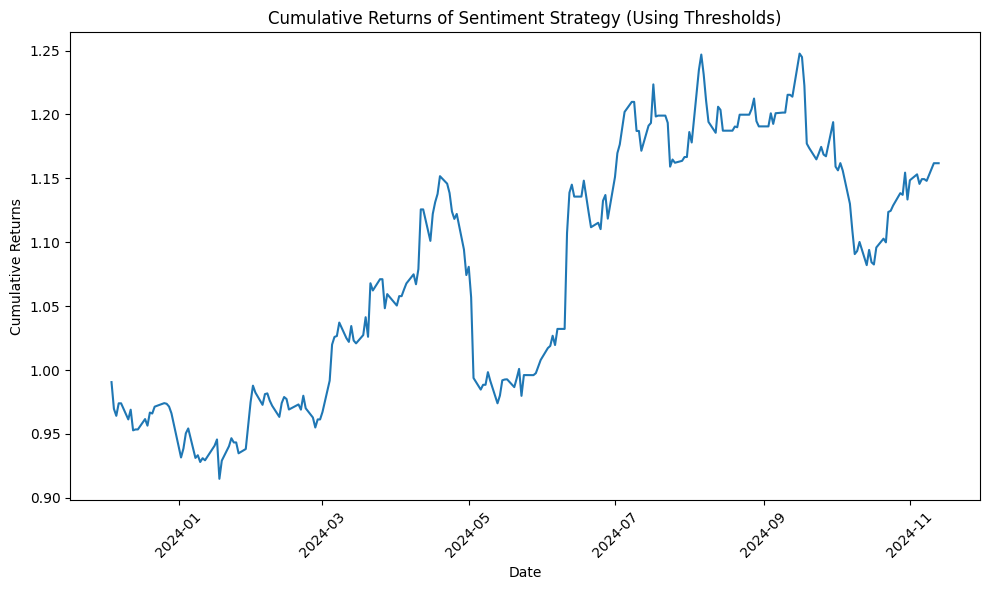

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

test_returns = merged_df['Return']
test_dates = merged_df['date']

# Define threshold values for sentiment-based trading signals
thresholds = {
    'Positive_Proportion': 0.6,  # Buy when positive sentiment > 60%
    'Negative_Proportion': 0.2   # Sell when negative sentiment > 20%
}

# Function to generate trading signals based on sentiment thresholds
def generate_signals(row, thresholds):
    signal = 0  # Default no trade (0)

    # Buy signal (1) when positive sentiment is higher than the threshold
    if row['Positive_Proportion'] > thresholds['Positive_Proportion']:
        signal = 1  # Buy

    # Sell signal (-1) when negative sentiment is higher than the threshold
    elif row['Negative_Proportion'] > thresholds['Negative_Proportion']:
        signal = -1  # Sell

    return signal

# Apply signal generation function to each row of the data
merged_df['Signal'] = merged_df.apply(lambda row: generate_signals(row, thresholds), axis=1)

# Calculate the strategy returns based on the generated signals
shifted_returns = test_returns#.shift(1)  # Use previous day's return for today's decision
strategy_returns = merged_df['Signal'].shift(1) * shifted_returns  # Trading signal applied to returns
strategy_cumulative_returns = (1 + strategy_returns).cumprod()

# Plot the cumulative returns of the strategy
plt.figure(figsize=(10, 6))
sns.lineplot(x=pd.to_datetime(test_dates), y=strategy_cumulative_returns)
plt.title('Cumulative Returns of Sentiment Strategy (Using Thresholds)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

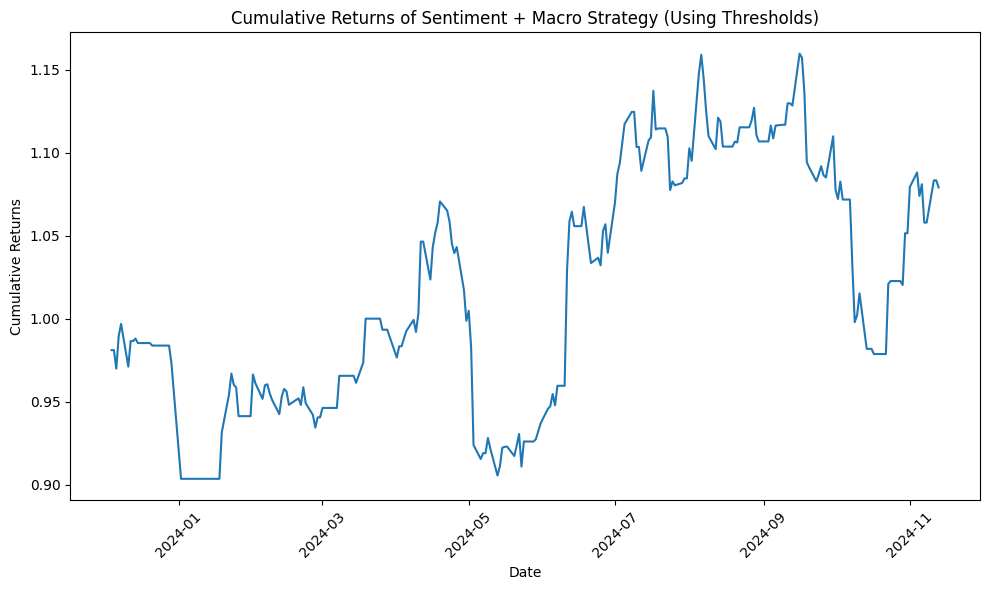

In [ ]:
## This incorporates a more complicated strategy, including some Macro-economic indicators
## I assumed some arbitrary thresholds where we might assume AAPL stock will decrease
import numpy as np
# Mean and Standard Deviation values from describe() output for thresholds
mean_interest_rate = 5.25
std_interest_rate = 0.17

mean_inflation_rate = 312.79
std_inflation_rate = 2.00

mean_unemployment_rate = 3.99
std_unemployment_rate = 0.19

# Define the thresholds using mean ± std logic for economic indicators
thresholds = {
    'Positive_Proportion': 0.6,  # Buy when positive sentiment > 60%
    'Negative_Proportion': 0.2,  # Sell when negative sentiment > 20%
    'Inflation Rate': mean_inflation_rate + std_inflation_rate,  # Sell when inflation rate exceeds mean + std
    'Interest Rate': mean_interest_rate + std_interest_rate,  # Sell when interest rate exceeds mean + std
    'Unemployment Rate': mean_unemployment_rate - std_unemployment_rate  # Buy when unemployment rate is below mean - std
}


# Function to generate trading signals based on thresholds
def generate_advanced_signals(row, thresholds):
    signal1 = 0  # Default no trade (0)
    signal2 = 0

    # Buy signal (1) when conditions are met (positive sentiment > 60%)
    if row['Positive_Proportion'] > thresholds['Positive_Proportion']:
        signal1 = 1  # Buy

    # Sell signal (-1) when conditions are met (negative sentiment > 20%)
    elif row['Negative_Proportion'] > thresholds['Negative_Proportion']:
        signal1 = -1  # Sell

    # Additional signals based on economic indicators
    if row['Inflation Rate'] > thresholds['Inflation Rate']:
        signal2 = -1  # Sell if inflation rate is higher than the threshold
    elif row['Interest Rate'] > thresholds['Interest Rate']:
        signal2 = -1  # Sell if interest rate is higher than the threshold
    elif row['Unemployment Rate'] < thresholds['Unemployment Rate']:
        signal2 = 1  # Buy if unemployment rate is below the threshold
    # Combine the two signals
    combined_signal = signal1 + signal2

    return combined_signal

# Apply signal generation function to each row of the data
merged_df['Signal'] = merged_df.apply(lambda row: generate_advanced_signals(row, thresholds), axis=1)

# Calculate the strategy returns based on the generated signals
shifted_returns = test_returns#.shift(1)  # Use previous day's return for today's decision
strategy_returns = merged_df['Signal'].shift(1) * shifted_returns  # Trading signal applied to returns
strategy_cumulative_returns = (1 + strategy_returns).cumprod()

# Plot the cumulative returns of the strategy
plt.figure(figsize=(10, 6))
sns.lineplot(x=pd.to_datetime(test_dates), y=strategy_cumulative_returns)
plt.title('Cumulative Returns of Sentiment + Macro Strategy (Using Thresholds)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# STAT 682 - Question6 - Scenario-Based Risk Assessment Using Synthetic Data and Generative Models

- Use a generative model to simulate a high-volatility market scenario (e.g., a sudden crash or bull market). Generate synthetic price data for this scenario and assess the impact on the risk metrics (e.g., Value at Risk (VaR), Expected Shortfall) of a hypothetical portfolio containing stocks A and B.
- Evaluate the robustness of your model when applied to scenarios not encountered in the training data. Discuss potential methods for improving the model’s performance under these novel conditions and the ethical considerations of relying on synthetic data in high-stakes financial decision-making.